In [43]:
import os
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import numpy as np
import h5py
from tqdm import tqdm
from peft import LoraConfig, get_peft_model
from aion.model import AION
from aion.codecs import CodecManager
from aion.modalities import LegacySurveyImage
from aion.modalities import (
    LegacySurveyImage,
    DESISpectrum,
    LegacySurveyFluxG,
    LegacySurveyFluxR,
    LegacySurveyFluxI,
    LegacySurveyFluxZ,
    Z,
)
# Configuration

LEARNING_RATE = 1e-4
NUM_WORKERS = 4
NSAMPLES = 5000
SEED = 42
device = 'cuda:0'

# Load data
test_file = h5py.File('../chto/astrofm/semi_supervised_only_tq_train_i_snr_20_32bit.hdf5', 'r+')

from matplotlib import colors
import numpy as np
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
plt.style.use("MNRAS_Style")


In [44]:

# Custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, images, flux, labels):
        self.images = images
        self.fluxes = flux
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.fluxes[idx], self.labels[idx]

# Create splits
labels = test_file['redshifts'][:].astype(np.float32)
images = test_file['images'][:, 1:5, :, :].astype('float32')
fluxes = 10**((test_file['mags'][:,1:5]-22.5)/2.5).astype('float32')
rng = np.random.default_rng(SEED)
random_idxs = rng.choice(len(labels), len(labels), replace=False)

train_images = images[random_idxs[:NSAMPLES]]
train_flux = fluxes[random_idxs[:NSAMPLES]]
train_labels = labels[random_idxs[:NSAMPLES]]
val_images = images[random_idxs[NSAMPLES:int(1.1*NSAMPLES)]]
val_flux = fluxes[random_idxs[NSAMPLES:int(1.1*NSAMPLES)]]

val_labels = labels[random_idxs[NSAMPLES:int(1.1*NSAMPLES)]]
test_images = images[random_idxs[int(1.1*NSAMPLES):int(1.2*NSAMPLES)]]
test_flux = fluxes[random_idxs[int(1.1*NSAMPLES):int(1.2*NSAMPLES)]]
test_labels = labels[random_idxs[int(1.1*NSAMPLES):int(1.2*NSAMPLES)]]

train_dataset = SequenceDataset(train_images, train_flux,train_labels)
val_dataset = SequenceDataset(val_images, val_flux, val_labels)
test_dataset = SequenceDataset(test_images, test_flux, test_labels)

print(f"✓ Data split created:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val: {len(val_dataset):,} samples")
print(f"  Test: {len(test_dataset):,} samples\n")


✓ Data split created:
  Train: 5,000 samples
  Val: 500 samples
  Test: 500 samples



In [45]:

# Initialize codec manager
codec_manager = CodecManager(device="cuda:0")

# Load base model
print("Loading AION base model...")
model = AION.from_pretrained("polymathic-ai/aion-base")

# Configure LoRA
lora_config = LoraConfig(
    r=40, # Reduced from 10 for less memory
    lora_alpha=32,
    target_modules=["q", "proj"],
    lora_dropout=0.1,
    bias="none",
)

print("Applying LoRA adapters...")
ft_model = get_peft_model(model, lora_config)


Loading AION base model...
Applying LoRA adapters...


In [46]:

# Custom regression model with proper multi-GPU support
class RegressionModel(nn.Module):
    def __init__(self, base_model, codec_manager):
        super().__init__()
        self.base_model = base_model
        self.codec_manager = codec_manager
        self.regressor = nn.Linear(768, 1)
    
    def forward(self, inputs, inputs2):
        # Encode on single GPU to avoid redundant encoding
        with torch.no_grad():
            inputs_encoded = self.codec_manager.encode(
                LegacySurveyImage(
                    flux=inputs.to('cuda:0'), 
                    bands=["DES-G", "DES-R", "DES-I", "DES-Z"]
                ),
                LegacySurveyFluxG(value=inputs2[:,0].to('cuda:0')),
                LegacySurveyFluxR(value=inputs2[:,1].to('cuda:0')),
                LegacySurveyFluxI(value=inputs2[:,2].to('cuda:0')),
                LegacySurveyFluxZ(value=inputs2[:,3].to('cuda:0')),
            )
        
        # Move to appropriate device for model
        inputs_encoded = {k: v.to(inputs.device) for k, v in inputs_encoded.items()}
        
        # Encode through AION
        outputs = self.base_model.encode(inputs_encoded, num_encoder_tokens=900)
        pooled_output = outputs.mean(dim=1)
        
        return self.regressor(pooled_output).squeeze(-1)

# Create model and wrap with DataParallel
regression_model = RegressionModel(ft_model, codec_manager)
#regression_model = nn.DataParallel(regression_model, device_ids=[0, 1, 2, 3])
regression_model = regression_model.to(device)


In [47]:

def print_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    print(f"  Trainable params: {trainable_params:,}")
    print(f"  Total params: {all_params:,}")
    print(f"  Trainable: {100 * trainable_params / all_params:.2f}%")

print("\n🎯 Model Architecture:")
print("-" * 60)
print_trainable_parameters(regression_model)
print("-" * 60)



🎯 Model Architecture:
------------------------------------------------------------
  Trainable params: 2,949,889
  Total params: 317,205,505
  Trainable: 0.93%
------------------------------------------------------------


In [48]:
BATCH_SIZE = 128  # Reduced from 200 - adjust based on your GPU memory
NUM_EPOCHS = 500
LEARNING_RATE = 1e-4

In [49]:

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS)

# Setup optimizer and loss
optimizer = AdamW(filter(lambda p: p.requires_grad, regression_model.parameters()), 
                 lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

print("\n✓ Model and data loaders ready!\n")

# Training loop
print("🚀 STARTING LORA FINE-TUNING")
print("=" * 70)


✓ Model and data loaders ready!

🚀 STARTING LORA FINE-TUNING


/project/chto/chto/anaconda/newenv4/lib/python3.10/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [50]:
device='cuda:0'

In [51]:

"""
best_val_loss = float('inf')

for ep in range(NUM_EPOCHS):
    # Training
    regression_model.train()
    train_loss_sum = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{NUM_EPOCHS} [Train]")
    for inputs, input2, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        input2=input2.to(device)
        
        optimizer.zero_grad()
        
        try:
            preds = regression_model(inputs,input2)
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()
            
            train_loss_sum += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"\n⚠️  OOM Error - Skipping batch. Consider reducing batch size.")
                torch.cuda.empty_cache()
                continue
            else:
                raise e
    
    avg_train_loss = train_loss_sum / len(train_loader)
    
    # Validation
    regression_model.eval()
    val_loss_sum = 0.0
    
    with torch.no_grad():
        for inputs, inputs2, labels in tqdm(val_loader, desc=f"Epoch {ep+1}/{NUM_EPOCHS} [Val]", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs2 = inputs2.to(device)
            preds = regression_model(inputs,inputs2)
            loss = loss_fn(preds, labels)
            val_loss_sum += loss.item()
    
    avg_val_loss = val_loss_sum / len(val_loader)
    
    print(f"Epoch {ep+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(regression_model.state_dict(), 'best_model2.pt')
        print(f"  ✓ Saved best model (val_loss: {best_val_loss:.4f})")
    
    # Clear cache periodically
    if (ep + 1) % 10 == 0:
        torch.cuda.empty_cache()

print("\n" + "=" * 70)
print("✓ Fine-tuning complete!")
print("=" * 70)

# Test evaluation
"""

'\nbest_val_loss = float(\'inf\')\n\nfor ep in range(NUM_EPOCHS):\n    # Training\n    regression_model.train()\n    train_loss_sum = 0.0\n    \n    pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{NUM_EPOCHS} [Train]")\n    for inputs, input2, labels in pbar:\n        inputs = inputs.to(device)\n        labels = labels.to(device)\n        input2=input2.to(device)\n        \n        optimizer.zero_grad()\n        \n        try:\n            preds = regression_model(inputs,input2)\n            loss = loss_fn(preds, labels)\n            loss.backward()\n            optimizer.step()\n            \n            train_loss_sum += loss.item()\n            pbar.set_postfix({"loss": f"{loss.item():.4f}"})\n            \n        except RuntimeError as e:\n            if "out of memory" in str(e):\n                print(f"\n⚠️  OOM Error - Skipping batch. Consider reducing batch size.")\n                torch.cuda.empty_cache()\n                continue\n            else:\n                raise e\n

In [52]:
#best fit model is here 
#https://drive.google.com/drive/folders/1lYABnGoLzzuo6eBVtAJBwvFnuW2ZOeVa?usp=sharing
#To load best fit model
regression_model.load_state_dict(torch.load("./best_model2.pt", weights_only=True))


<All keys matched successfully>

In [53]:
# Evaluate on test set
print("🔄 Evaluating on test set...\n")
regression_model.eval()
test_predictions = []
labels_all = []
for inputs, inputs2, labels in tqdm(train_loader, desc="Testing"):
    with torch.no_grad():
        preds = regression_model(inputs, inputs2).cpu().numpy()
        test_predictions.extend(preds)
        labels_all.extend(labels)
test_predictions = np.array(test_predictions)


🔄 Evaluating on test set...



Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:26<00:00,  1.53it/s]


In [54]:
test_predictions 

array([0.39729565, 1.7377945 , 0.5010623 , ..., 0.6973595 , 0.4880075 ,
       1.1617577 ], dtype=float32)

In [59]:
plt.rcParams['font.family'] = '/home/chto/helvetica/Helvetica.ttf'


In [61]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# Path to your .ttf file
font_path = "/home/chto/helvetica/Helvetica.ttf"

# Create a FontProperties object
prop = fm.FontProperties(fname=font_path)

In [65]:
fm.fontManager.addfont(font_path)


plt.rcParams['font.family'] = 'Helvetica'  # Replace with the actual font name


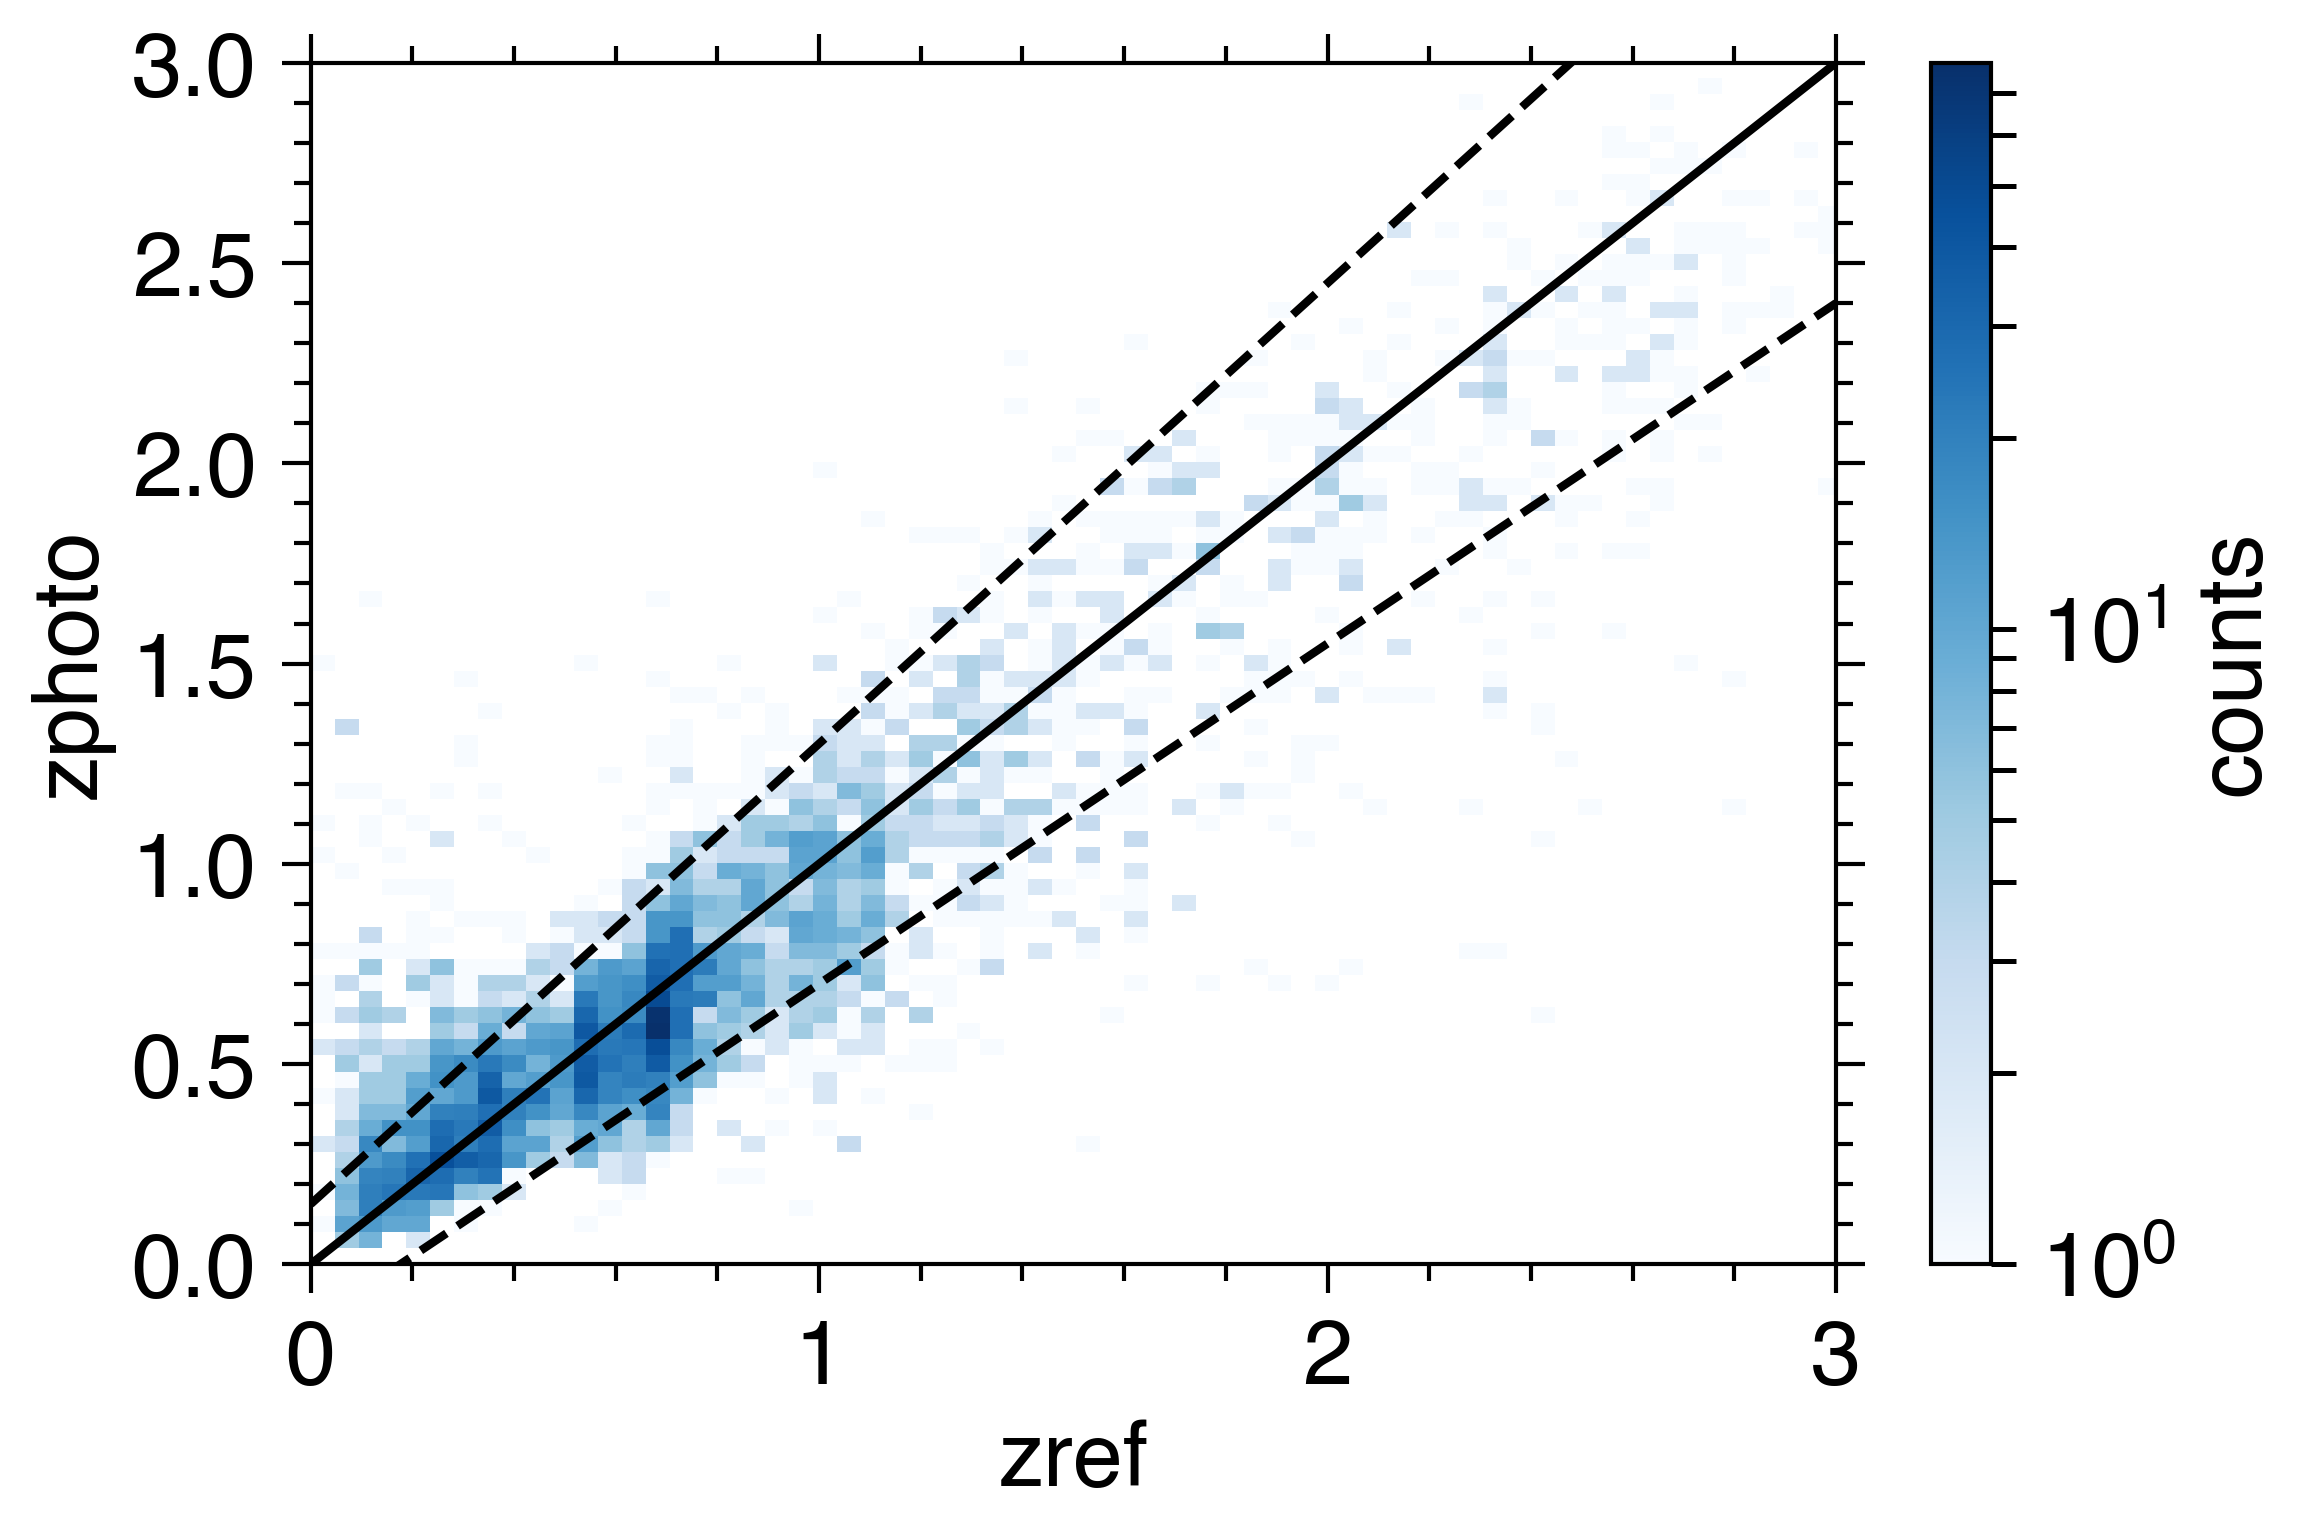

In [72]:

fig,ax = plt.subplots(figsize=(8.2,5.2), dpi=300)
h = plt.hist2d(labels_all, test_predictions,
           bins = 100, 
           cmap = "Blues",
           norm = colors.LogNorm())
cbar = fig.colorbar(h[3], ax=ax)
cbar.ax.set_ylabel("counts")
plt.plot(np.linspace(0,3,10), np.linspace(0,3,10), c='k')
plt.plot(np.linspace(0,3,10), (1+np.linspace(0,3,10))*0.15+np.linspace(0,3,10), c='k', ls="--")
plt.plot(np.linspace(0,3,10),  -1*(1+np.linspace(0,3,10))*0.15+np.linspace(0,3,10), c='k', ls="--")
plt.xlabel("zref")
plt.tick_params(axis='x', direction='out')  # only x-axis
plt.tick_params(axis='y', direction='out')  # only y-axis
ax.tick_params(axis='both', which='both', direction='out')
cbar.ax.tick_params(direction='out', axis='both')
cbar.minorticks_on()

# Make both major and minor ticks point outward
cbar.ax.tick_params(which='both', direction='out', length=6, width=1.2)
plt.ylabel("zphoto")
plt.xlim(0,3)
plt.ylim(0,3)
plt.savefig("test.png")

In [189]:
def r2_score(y_true, y_pred):
    """
    Compute the coefficient of determination R^2.

    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated target values.

    Returns
    -------
    float
        R^2 score.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

In [190]:
 r2_score(labels_all, test_predictions)

np.float32(0.8354304)

In [19]:
def calculate_stats(y, y_pred, outlier_f=0.15):
    delta = (y_pred - y)/(1+y)
    bias = np.mean(delta)
    nmad = 1.4826*np.median(np.abs(delta - np.median(delta)))
    outlier_fraction = np.sum(np.abs(delta)>outlier_f)/len(y)
    nmad_err = nmad/np.sqrt(2*len(y))
    outlier_f_error = np.sqrt(outlier_fraction*(1-outlier_fraction)/len(y))
    return bias, nmad, outlier_fraction, nmad_err, outlier_f_error


In [20]:
calculate_stats(np.array(labels_all), test_predictions)

(np.float32(0.002263573),
 np.float32(0.10188968),
 np.float64(0.1838),
 np.float64(0.0010188967734575272),
 np.float64(0.005477546165939635))

In [10]:
test_file.keys()

<KeysViewHDF5 ['decs', 'ebvs', 'features', 'features_dr', 'images', 'mags', 'mags_dr', 'objectId', 'ras', 'redshifts', 'use_redshift_1']>

In [11]:
test_file = h5py.File('../chto/astrofm/semi_supervised_only_tq_train_i_snr_20_32bit.hdf5', 'r+')


In [12]:
from scipy.spatial import cKDTree
tree = cKDTree(np.array([test_file['ras'][:],test_file['decs'][:]]).T)

In [13]:
spectra = np.genfromtxt("../chto/astrofm/cesam_vvds_spCDFS_DEEP_Full.txt.gz")

In [14]:
dis, idx2 = tree.query(spectra[:, [2,3]], k=1)

In [15]:
m = dis<1E-5
np.where(m)

(array([  82,  132,  266,  267,  396,  444,  472,  656,  660,  669,  709,
         716,  742,  778,  797,  803,  836,  869,  871,  910,  957, 1170,
        1469]),)

In [16]:
spectra[m,0]

array([12018., 13163., 15757., 15789., 18400., 19224., 19797., 24503.,
       24525., 24659., 25365., 25438., 26231., 27296., 27894., 28091.,
       29029., 29351., 29376., 30216., 31105., 36385., 77387.])

In [17]:
idx=idx2[m]

In [18]:
test_file.keys()

<KeysViewHDF5 ['decs', 'ebvs', 'features', 'features_dr', 'images', 'mags', 'mags_dr', 'objectId', 'ras', 'redshifts', 'use_redshift_1']>

In [19]:
images = test_file['images'][:][idx][:,1:5]
mags = test_file['mags'][:][idx][:, 1:5]
fluxes = 10**((mags-22.5)/2.5)


In [20]:
def to_tensor(data_array, dtype="float32"):
    return torch.tensor(np.array(data_array).astype(dtype), device='cuda:0')

In [21]:
images.shape

(23, 4, 108, 108)

In [22]:
fluxes.shape

(23, 4)

In [23]:
model = AION.from_pretrained("polymathic-ai/aion-base")


In [24]:
in1 = images
inputs2 = fluxes
inputs_encoded = codec_manager.encode(
        LegacySurveyImage(
            flux= to_tensor(in1),
            bands=["DES-G", "DES-R", "DES-I", "DES-Z"]
        ),
        LegacySurveyFluxG(value=to_tensor(inputs2[:,0,])),
        LegacySurveyFluxR(value=to_tensor(inputs2[:,1])),
        LegacySurveyFluxI(value=to_tensor(inputs2[:,2])),
        LegacySurveyFluxZ(value=to_tensor(inputs2[:, 3])),
    )

# Move to appropriate device for model
inputs_encoded = {k: v.to('cuda:0') for k, v in inputs_encoded.items()}

# Encode through AION
outputs = model(inputs_encoded,  target_modality=DESISpectrum,)

In [38]:
# Get the token key for the DESI spectrum
token_key = DESISpectrum.token_key
# Get the predicted token by taking the argmax of the logits
pred_token = {token_key: outputs[token_key].softmax(dim=-1).argmax(dim=-1).to('cuda:0')}  # B x tokens#

In [26]:
pred_token['tok_spectrum_desi'][0]

tensor([303,  12,  12,  12,  12,  12,  12,  12,  12,  42,  42,  42, 783, 783,
         10,  10,  10,  42,  42,  42,  42, 815, 815, 815,  42,  42,  42,  42,
        935, 943, 943, 943, 943, 815, 943, 943, 943, 935, 935, 935, 935, 935,
        935, 943, 943, 935, 935,  42,  42,  42,  42,  42,  42,  42,  42,  42,
         42,  42,  26,  26,  26,  42,  42,  42, 937, 431, 431, 431, 431, 431,
        431, 431, 431, 431,  42, 431, 431, 431, 431, 943, 943,  26,  26,  26,
         26,  26,  26,  26,  26, 943, 943,  26,  26,  26,  42,  58,  58, 935,
        935, 935, 935, 935, 431, 431,  42, 935, 935,  42,  42, 431, 431, 431,
        431, 431, 431, 431, 431, 431, 431, 431, 831, 431, 431, 431, 431, 431,
        431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431,
        445, 431, 431, 431, 431, 431, 431, 431, 935, 935, 297, 297, 445, 445,
        431, 431, 297, 297, 297, 445, 445, 445, 445, 445, 445, 831, 431, 431,
        445, 445, 445, 445, 445, 445, 935, 935, 431, 445, 445, 9

In [27]:
outputs[token_key].softmax(dim=-1).argmax(dim=-1).shape

torch.Size([23, 273])

In [28]:
import fitsio
spec_ref, h = fitsio.read("../chto/astrofm/CDF_DEEP/1D/sc_000015789_CDFS002_vmM1_red_98_1_atm_clean.fits", ext=0, header=True)

In [29]:
CRVAL1  = h['CRVAL1']
CDELT1  = h['CDELT1']
NAXIS1  = h ['NAXIS1']

In [30]:
lambdax = np.arange(NAXIS1)*CDELT1+CRVAL1

In [31]:
def smooth_moving_average(x, y, window_size=10):
    """Smooth y values using a simple moving average with given window size."""
    if window_size < 2:
        return x, y
    kernel = np.ones(window_size) / window_size
    y_smooth = np.convolve(y, kernel, mode='same')
    return x, y_smooth

In [34]:
ind = 20
import glob
fname = glob.glob("../chto/astrofm/CDF_DEEP/1D/sc_0000{0}*_clean.fits".format(int(spectra[m,0][ind])))
spec_ref, h = fitsio.read(fname[0], ext=0, header=True)


In [37]:
pred_token

{'tok_spectrum_desi': tensor([[303,  12,  12,  ..., 821, 821, 821],
         [909, 303, 303,  ..., 565, 565, 565],
         [303,  13,  12,  ..., 823, 821, 821],
         ...,
         [297, 303, 303,  ..., 431, 565, 565],
         [445, 316, 316,  ..., 830, 565, 565],
         [297,   9,  12,  ..., 565, 565, 565]])}

Text(0, 0.5, 'flux')

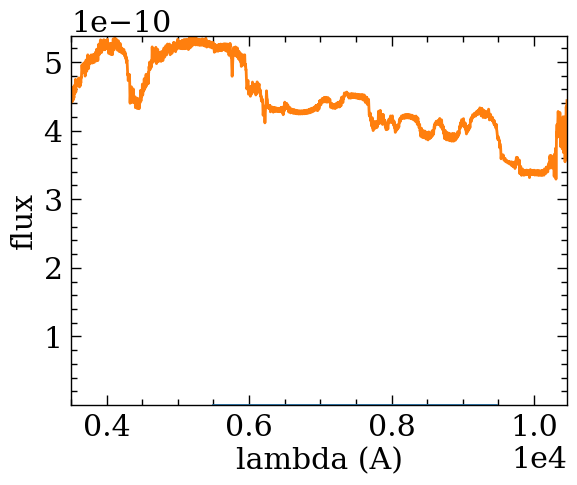

In [41]:
from scipy.ndimage import gaussian_filter1d
cspec = codec_manager.decode(pred_token,DESISpectrum,)
xnew, ynew = lambdax[::1], spec_ref[0][::1]
plt.plot(xnew, gaussian_filter1d(ynew,2))
xnew, ynew = np.array(cspec.wavelength.cpu())[ind], np.array(cspec.flux.cpu()[ind])/10**10
plt.plot(xnew, gaussian_filter1d(ynew,2))
#plt.axvline(4000*(1+preds.cpu().detach())[ind], c='k')
#plt.ylim(0.8,1.5)
#plt.xscale('log')
plt.xlabel("lambda (A)")
plt.ylabel("flux")
#plt.xlim(6000,10000)